# Architecture

Classical -> quantum layer -> classical

8 input features -> 8 neurons -> 10 neurons -> quantum layer -> 2 neurons -> 4 output neurons
```                                    _________             __________
|0>----[D(y1,y2)]-[S(y3,y4)]-[Φ(y5) ]-|U1(θ1,Φ1)|--[S(s1)]--| U2(θ2,Φ2)|--[Dα1]--[Φk1]--
|0>----[D(y6,y7)]-[S(y8,y9)]-[Φ(y10)]-|_________|--[S(s2)]--|__________|--[Dα2]--[Φk2]--
```

# Strawberry fields through pennylane -> similar to my code of HQNN, just have to change the circuit

## Dataset prep

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import random

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Generate the dataset
X, y = make_classification(
    n_samples=1000,         
    n_features=8,           
    n_informative=8,        
    n_redundant=0,          
    n_repeated=0,           
    n_classes=4,            
    n_clusters_per_class=3, 
    class_sep=3.0,          
    flip_y=0.02,            
    random_state=RANDOM_STATE
)

# Normalize features to [0, 1] (to simulate photonic input transmission)
scaler = MinMaxScaler(feature_range=(0, 1))
X_normalized = scaler.fit_transform(X)

# Convert to DataFrame for saving
df = pd.DataFrame(X_normalized, columns=[f"feature_{i}" for i in range(X_normalized.shape[1])])
df["label"] = y

# Save to CSV
csv_filename = "photonic_classification_dataset.csv"
df.to_csv(csv_filename, index=False)

print(df.head())


   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.313548   0.698436   0.655915   0.512419   0.540910   0.379305   
1   0.879835   0.179504   0.279735   0.753262   0.444141   0.435591   
2   0.952022   0.469510   0.861085   0.622264   0.616624   0.190033   
3   0.511152   0.838636   0.301667   0.598204   0.417735   0.831927   
4   0.348271   0.803671   0.358219   0.772329   0.489137   0.636509   

   feature_6  feature_7  label  
0   0.797181   0.396185      2  
1   0.456242   0.438114      0  
2   0.856493   0.369225      1  
3   0.184893   0.846957      2  
4   0.201562   0.297139      1  


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

def prepare_data(approach_3_df: pd.DataFrame, sample_size: int, batch_size: int):
   
    # Subsample data
    if sample_size < len(approach_3_df):
        data_df = approach_3_df.sample(n=sample_size, random_state=42)
    else:
        data_df = approach_3_df.copy()

    #  Split features and labels
    X = data_df.iloc[:, :-1].values.astype(np.float32)
    y = data_df.iloc[:, -1].values

    y = y.astype(np.int64)

    #  Split train / val / test (80/10/10)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    #  Convert to PyTorch tensors
    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    val_dataset   = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
    test_dataset  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

    #  Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


## Models

## HQPNN

In [43]:
import sys
print(sys.executable)


c:\Users\prane\HQPNN_2\Scripts\python.exe


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pennylane as qml
import math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import time
import random
import os
import json
import csv
from strawberryfields.decompositions import rectangular_compact
import torch.backends.cudnn as cudnn
import collections

In [ ]:
# Set the GPU you want to use (None as of now)

# NUM_QUBITS = 2 (for now lets simulate the exact circuit as in the figure from paper i.e. with 2 qumodes)


os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU0 

def run():
    # =====================
    # 2. GPU Configuration
    # =====================
    if USE_GPU and not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available. This script requires a GPU.")

    device = torch.device("cuda" if USE_GPU else "cpu")
    print(f"Using device: {device}")
    print(f"PyTorch CUDA version: {torch.version.cuda}")

    dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=10)

    # =====================
    # 3. Quantum Circuit
    # =====================

    def make_unitary(theta, phi): 
        theta_np = theta.detach().numpy()
        phi_np   = phi.detach().numpy()
    
        U = np.array([
            [np.cos(theta_np), -np.exp(1j * phi_np) * np.sin(theta_np)],
            [np.sin(theta_np),  np.exp(1j * phi_np) * np.cos(theta_np)]
        ])
    
        return U
    
    # Quantum circuit (single shot for one input only)
    @qml.qnode(dev, interface="torch", diff_method='parameter-shift')
    
    def quantum_circuit(inputs, weights):

        '''
        For the photonic circuit inputs is an array of 10 elements (y0-y10) or 5 per qmode and weights is an array or the trainable params of other gates
        For now lets have a static circuit for 2 qmodes as shown in figure 1
        '''
        # Unpacking input elements
        #print(len(inputs))
        #print(inputs)
        y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 =  inputs
        #a,  p,  a,  p,  a,  a,  p,  a,  p,  a (a for amplitude and p for phase for refernce when indexing later at the time of encoding)
        # Unpack trainable weights
        theta1, phi1, s1, s2, theta2, phi2, alpha1, alpha2, k1, k2 = weights
        
        qml.Displacement(y1, y2, wires=0)
        qml.Squeezing(y3, y4, wires=0)
        qml.Kerr(y5, wires=0)
    
        qml.Displacement(y6, y7, wires=1)
        qml.Squeezing(y8, y9, wires=1)
        qml.Kerr(y10, wires=1)

        # ===== first interferometer =====
        U1 = make_unitary(theta1, phi1)
        qml.InterferometerUnitary(U1, wires=[0,1])

        # ===== squeezing layer =====
        qml.Squeezing(s1, 0.0, wires=0)
        qml.Squeezing(s2, 0.0, wires=1)
        
        # ===== second interferometer =====
        U2 = make_unitary(theta2, phi2)
        qml.InterferometerUnitary(U2, wires=[0,1])
        
        # ===== output layer =====
        qml.Displacement(alpha1, 0.0, wires=0)
        qml.Displacement(alpha2, 0.0, wires=1)
        qml.Kerr(k1, wires=0)
        qml.Kerr(k2, wires=1)
        
        # ===== measurement =====
        return [qml.expval(qml.X(wires=0)), qml.expval(qml.X(wires=1))]


    class QuantumLayer(nn.Module):
        def __init__(self):
            super().__init__()
            # theta1, phi1, s1, s2, theta2, phi2, alpha1, alpha2, k1, k2 = weights
            self.weights = nn.Parameter(0.01 * torch.randn(10, device=device))
 
        def forward(self, inputs):
            exp_vals = []
            for i in range(inputs.shape[0]):
                exp_vals.append(quantum_circuit(inputs[i], self.weights))
            return torch.stack(exp_vals, dim=0)
  
    # Pre-autoencoder
    class PreAutoencoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Linear(INPUT_DIM, HIDDEN_DIM),
                nn.ReLU(),
                nn.Linear(HIDDEN_DIM, 10), # 10 as we have 10 inputs y1-y10
                nn.Tanh(),
            )

        def forward(self, x):
            # Apply the encoder to the input data
            encoded = self.encoder(x)  # shape: (batch_size, NUM_QUBITS)
            return encoded
        
    # Post-autoencoder
    class PostAutoencoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.decoder = nn.Sequential(
                nn.Linear(NUM_QUBITS, POST_HIDDEN_DIM),
                nn.ReLU(),
                nn.Linear(POST_HIDDEN_DIM, FINAL_OUTPUT_DIM),
            )

        def forward(self, x):
            return self.decoder(x)
        
    # Full hybrid model
    class HybridQNN(nn.Module):
        def __init__(self, pre_encoder, quantum_layer, post_decoder):
            super().__init__()
            self.pre_encoder = pre_encoder
            self.quantum_layer = quantum_layer
            self.post_decoder = post_decoder

        def forward(self, x):
            encoded = self.pre_encoder(x)  # shape: (batch_size, NUM_QUBITS)

            # Separate indices for amplitude vs phase parameters per qumode

            # ==============================================================================================================================================
            # ==============================================================================================================================================
            # ==============================================================================================================================================

            # for now lets set amax to 1 , since the paper does not have supplementary note III that is supposed to have the method
            amax = 1
            # ==============================================================================================================================================
            # ==============================================================================================================================================
            # ==============================================================================================================================================
            
            #y0, y1, y2, y3, y4, y5, y6, y7, y8, y9 =  inputs
            #a,  p,  a,  p,  a,  a,  p,  a,  p,  a

            amplitudes = torch.sigmoid(encoded[:, [0,2,4,5,7,9]]) * amax
            phases     = torch.sigmoid(encoded[:, [1,3,6,8]]) * 2 * math.pi

            # Combine them back in the order your quantum_circuit expects
            quantum_inputs = torch.zeros_like(encoded)
            quantum_inputs[:, [0,2,4,5,7,9]] = amplitudes
            quantum_inputs[:, [1,3,6,8]] = phases

            #quantum_out = self.quantum_layer(quantum_inputs)
            quantum_out = self.quantum_layer(quantum_inputs).to(torch.float32)
            return self.post_decoder(quantum_out)
        
    # Instantiate model components
    pre_ae = PreAutoencoder().to(device)
    quantum_layer = QuantumLayer().to(device)
    post_ae = PostAutoencoder().to(device)
    model = HybridQNN(pre_ae, quantum_layer, post_ae).to(device)

    # 4. Training Loop Setup                  
    train_loader, val_loader, test_loader = prepare_data(approach_3_df=DATA, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE)

    # 5. Optimizer Setup
    optimizer = optim.AdamW([
        {'params': model.pre_encoder.parameters(), 'lr': LR_PRE_ENCODER, 'weight_decay': WEIGHT_DECAY},
        {'params': model.quantum_layer.parameters(), 'lr': LR_QUANTUM},
        {'params': model.post_decoder.parameters(), 'lr': LR_POST_DECODER, 'weight_decay': WEIGHT_DECAY}
    ])

    # 6. Learning Rate Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=LR_SCHEDULER_FACTOR,
        patience=LR_SCHEDULER_PATIENCE)

    # 7. Mixed Precision Support
    scaler = torch.GradScaler(device=device)

    # 8. Loss Function
    criterion = nn.CrossEntropyLoss()

    # 9. Training Loop 
    training_logs = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_epoch = 0
    train_losses = []
    val_losses = []
    learning_rates = []
    gradient_norms_total = []

    start_time = time.time()
    
    for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress", unit="epoch"):
        model.train()

        train_loss = 0.0

        epoch_grad_per_layer_sum = collections.OrderedDict()
        num_batches = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader, 1):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            inputs = inputs.to(device).to(torch.float32)

            with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=torch.cuda.is_available()):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)

            batch_grad_norms = collections.OrderedDict()
            for name, param in model.named_parameters():
                if param.grad is not None:
                    norm_val = param.grad.norm().item()
                    #print(f"Gradient norm for {name}: {norm_val:.4f}")
                    batch_grad_norms[name] = norm_val

                    if name not in epoch_grad_per_layer_sum:
                        epoch_grad_per_layer_sum[name] = 0.0
                    epoch_grad_per_layer_sum[name] += norm_val

            max_norm_value = 10.0
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm_value)

            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)
            num_batches += 1

        train_loss /= len(train_loader.dataset)
        epoch_grad_per_layer = {k: v / num_batches for k, v in epoch_grad_per_layer_sum.items()}

        # Calculate total gradient norm for the epoch (L2 norm over all grads)
        total_norm = 0.0
        for param in model.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        gradient_norms_total.append(total_norm)
        
        # === Validation ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

        scheduler.step(val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), SAVE_MODEL_PATH)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save logs for this epoch
        training_logs.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "gradient_norm_total": total_norm,
            "gradient_norm_layerwise": epoch_grad_per_layer,
            "learning_rate": optimizer.param_groups[0]["lr"]
        })

    training_time = (time.time() - start_time) / 60  # minutes

    # 10. Final Metrics Logging
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    generalization_gap = final_val_loss - final_train_loss
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # 11. Save Final Predictions
    model.eval()
    final_predictions = []
    final_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            final_predictions.append(outputs.cpu().numpy())
            final_labels.append(labels.cpu().numpy())

    # Convert to numpy arrays for easy saving
    final_predictions = np.concatenate(final_predictions, axis=0)
    final_labels = np.concatenate(final_labels, axis=0)

    # Save the predictions and labels to CSV
    os.makedirs('logs', exist_ok=True)
    np.savetxt(f'{model_name}_predictions.csv', final_predictions, delimiter=',')
    np.savetxt(f'{model_name}_labels.csv', final_labels, delimiter=',')

    # 12. Save Training Logs to JSON and CSV
    os.makedirs("logs", exist_ok=True)

    # Save training logs to JSON
    with open(f"{model_name}_logs.json", "w") as f:
        json.dump(training_logs, f, indent=4)

    # Save summary to CSV
    run_summary = {
        "model_id": model_name,
        "architecture": " ",
        "qubits": NUM_QUBITS,
        "depth": NUM_LAYERS,
        "batch_size": BATCH_SIZE,
        "sample_size": NUM_SAMPLES,
        "random_seed": RANDOM_SEED,
        "train_loss_final": final_train_loss,
        "val_loss_final": final_val_loss,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "final_grad_norm": training_logs[-1]["gradient_norm_total"],
        "generalization_gap": generalization_gap,
        "training_time_minutes": training_time,
        "num_params": num_params
    }

    csv_path = f"{model_name}_run_summaries.csv"
    write_headers = not os.path.exists(csv_path)
    with open(csv_path, "a", newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=run_summary.keys())
        if write_headers:
            writer.writeheader()
        writer.writerow(run_summary)

In [ ]:
l = [42]                            # random seeds
qubit_range = [2]                   # qubit range
layers_range = [2]                  # layers range
data_sample_size = [1000]           # sample size range

#config = [(qubit,layer).... for qubit in qubit_range for layer in layers_range]  # Define qubit and layer configurations 
config = [(2,2)]
c = 0

data1 = pd.read_csv('photonic_classification_dataset.csv')

# Dataset loop with (name, dataframe)
datasets = [("data1_name", data1)]  

for sample_size in data_sample_size:
    for num_qubit, layers in config:
        c += 1

        for DATA_NAME, DATA in datasets:  

            for rs in l:
                # General settings
                SAMPLE_SIZE = sample_size
                USE_GPU = False
                BATCH_SIZE = 32
                INPUT_DIM = 8
                HIDDEN_DIM = 10
                POST_HIDDEN_DIM = 2
                FINAL_OUTPUT_DIM = 4
                NUM_SAMPLES = SAMPLE_SIZE
                
                # Quantum settings
                NUM_QUBITS = num_qubit
                NUM_LAYERS = layers
                RANDOM_SEED = rs
                DIFF_METHOD = "parameter-shift"

                # Reproducibility
                torch.manual_seed(RANDOM_SEED)  # Set seed for CPU operations in PyTorch
                torch.cuda.manual_seed_all(RANDOM_SEED)  # Set seed for all CUDA devices 

                # Set seed for numpy operations
                np.random.seed(RANDOM_SEED)

                # Set seed for Python's built-in random module
                random.seed(RANDOM_SEED)

                # Ensure CUDA seed is also set if CUDA is available
                if torch.cuda.is_available():
                    torch.cuda.manual_seed_all(RANDOM_SEED)

                # Force deterministic behavior in cuDNN
                cudnn.deterministic = True  # Ensures that results are reproducible 
                cudnn.benchmark = False  # Disables the cuDNN auto-tuner that selects the best algorithm for hardware

                # Model name
                model_name = f"{DATA_NAME}_{sample_size}_{c}_{rs}"

                # Print configuration
                print(f"Running {model_name} | Dataset: {DATA_NAME} | "
                      f"Sample Size: {SAMPLE_SIZE} | Qubits: {NUM_QUBITS} | "
                      f"Layers: {NUM_LAYERS} | Seed: {RANDOM_SEED}")

                # Training settings
                NUM_EPOCHS = 100
                EARLY_STOP_PATIENCE = 5
                LR_PRE_ENCODER = 0.001
                LR_QUANTUM = 0.001          # set lower for quantum layer to ensure stable learning
                LR_POST_DECODER = 0.001
                WEIGHT_DECAY = 0.01
                LR_SCHEDULER_FACTOR = 0.5
                LR_SCHEDULER_PATIENCE = 3
                SAVE_MODEL_PATH = f"{model_name}.pth"

                # Run training
                run()
                    

print(f"\nTotal runs: {c}")

Running data1_name_1000_1_42 | Dataset: data1_name | Sample Size: 1000 | Qubits: 2 | Layers: 2 | Seed: 42
Using device: cpu
PyTorch CUDA version: None


Training Progress: 100%|██████████| 100/100 [1:24:02<00:00, 50.42s/epoch]



Total runs: 1


# Analysis

In [48]:
import pandas as pd
df = pd.read_csv('data1_name_1000_1_42_run_summaries.csv')
df

,model_id,architecture,qubits,depth,batch_size,sample_size,random_seed,train_loss_final,val_loss_final,best_val_loss,best_epoch,final_grad_norm,generalization_gap,training_time_minutes,num_params
0,data1_name_1000_1_42,,2,2,32,1000,42,0.668356,0.65689,0.651387,98,1.116219,-0.011466,84.035954,228


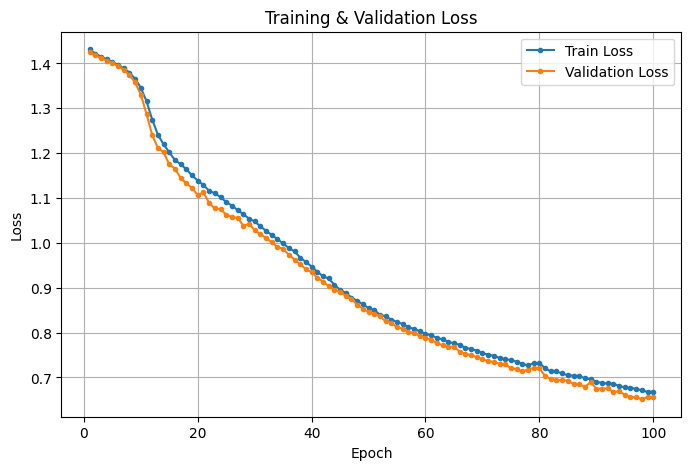

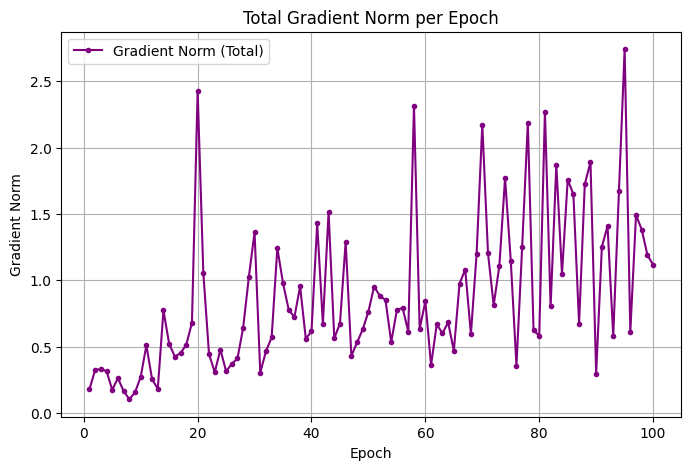

In [ ]:
# Plotting loss and gradient

import json
import matplotlib.pyplot as plt

# ---- Load JSON logs ----
with open("data1_name_1000_1_42_logs.json", "r") as f:
    logs = json.load(f)

epochs = [entry["epoch"] for entry in logs]

# Loss
train_loss = [entry["train_loss"] for entry in logs]
val_loss = [entry["val_loss"] for entry in logs]

# Gradient norms
grad_total = [entry["gradient_norm_total"] for entry in logs]

# ---- Plot Loss ----
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss", marker=".")
plt.plot(epochs, val_loss, label="Validation Loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Total Gradient Norm ----
plt.figure(figsize=(8,5))
plt.plot(epochs, grad_total, label="Gradient Norm (Total)", marker=".", color="purple")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Total Gradient Norm per Epoch")
plt.legend()
plt.grid(True)
plt.show()
